ΚΥΡΙΑ ΕΡΓΑΣΙΑ - ΝΕΥΡΩΝΙΚΑ ΔΙΚΤΥΑ & ΒΑΘΙΑ ΜΑΘΗΣΗ
Complete Project: MLP & CNN Experiments + Baseline Comparison

CIFAR-10 Classification with:
1. Baseline Classifiers (k-NN, NCC)
2. Multi-Layer Perceptron (MLP) - Multiple Configurations
3. Convolutional Neural Network (CNN) - Multiple Configurations
4. Comprehensive Comparison & Analysis

Author: Your Name
Date: November 2024




# **Libraries**

In [ ]:
from google.colab import drive
import os

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import time
import pickle
import pandas as pd
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import torchvision
import torchvision.transforms as transforms

# GPU Configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f"\nDevice: {device}")

if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
    print(f"CUDA Version: {torch.version.cuda}")

    # Optimize GPU settings
    torch.backends.cudnn.benchmark = True
    torch.backends.cudnn.enabled = True
    print("GPU optimizations enabled!")
else:
    print("WARNING: GPU NOT AVAILABLE!")
    print("Go to: Runtime → Change runtime type → T4 GPU")
    print("Then restart the runtime.")

# Set seeds
torch.manual_seed(42)
np.random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

print("Libraries imported successfully!")


Device: cuda
GPU: Tesla T4
Memory: 15.83 GB
CUDA Version: 12.6
GPU optimizations enabled!
Libraries imported successfully!


# **Save in Google Drive**

In [ ]:
# Mount Drive
drive.mount('/content/drive', force_remount=True)

# Create project folder
project_folder = '/content/drive/MyDrive/NN_CIFAR10_Project'
os.makedirs(project_folder, exist_ok=True)

print(f"Google Drive mounted!")
print(f"Project folder: {project_folder}")

# Save path for all outputs
SAVE_PATH = project_folder

Mounted at /content/drive
Google Drive mounted!
Project folder: /content/drive/MyDrive/NN_CIFAR10_Project


# **DATA LOADING**

In [ ]:
# Aggressive augmentation for high accuracy
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

# Load CIFAR-10
print("\nLoading CIFAR-10...")
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_train)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform_test)

# Split train/val
train_size = int(0.9 * len(trainset))
val_size = len(trainset) - train_size
trainset, valset = random_split(trainset, [train_size, val_size])

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

print(f"Train: {train_size:,} | Val: {val_size:,} | Test: {len(testset):,}")


Loading CIFAR-10...
Train: 45,000 | Val: 5,000 | Test: 10,000


# **BASELINE CLASSIFIERS (k-NN & NCC) with PCA**

In [ ]:
# Prepare data (use basic transforms for baseline)
transform_basic = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

trainset_basic = torchvision.datasets.CIFAR10(root='./data', train=True,
                                              download=True, transform=transform_basic)
testset_basic = torchvision.datasets.CIFAR10(root='./data', train=False,
                                             download=True, transform=transform_basic)

def prepare_classical_data(dataset, max_samples=None):
    loader = DataLoader(dataset, batch_size=1000, shuffle=False)
    X_list, y_list = [], []

    for images, labels in loader:
        X_list.append(images.numpy())
        y_list.append(labels.numpy())
        if max_samples and len(y_list) * 1000 >= max_samples:
            break

    X = np.vstack(X_list).reshape(len(np.hstack(y_list)), -1)
    y = np.hstack(y_list)
    return X, y

print("\nPreparing baseline data...")
X_train_flat, y_train_flat = prepare_classical_data(trainset_basic)
X_test_flat, y_test_flat = prepare_classical_data(testset_basic, max_samples=2000)

# Apply PCA
print("\nApplying PCA-25...")
pca = PCA(n_components=25, random_state=42)
X_train_pca = pca.fit_transform(X_train_flat)
X_test_pca = pca.transform(X_test_flat)
explained_var = pca.explained_variance_ratio_.sum() * 100

print(f"PCA: {X_train_flat.shape[1]}D → {X_train_pca.shape[1]}D")
print(f"Explained variance: {explained_var:.2f}%")

# k-NN & NCC
def knn_classifier(X_train, y_train, X_test, k=3):
    print(f"\nRunning {k}-NN...")
    start = time.time()
    predictions = np.zeros(len(X_test), dtype=int)

    for i in range(len(X_test)):
        if (i + 1) % 500 == 0:
            print(f"   {i+1}/{len(X_test)}")
        distances = np.sqrt(np.sum((X_train - X_test[i]) ** 2, axis=1))
        k_idx = np.argsort(distances)[:k]
        predictions[i] = Counter(y_train[k_idx]).most_common(1)[0][0]

    elapsed = time.time() - start
    acc = np.mean(predictions == y_test_flat) * 100
    print(f"{k}-NN: {acc:.2f}% ({elapsed:.1f}s)")
    return predictions, acc, elapsed

def ncc_classifier(X_train, y_train, X_test):
    print(f"\nRunning NCC...")
    start = time.time()
    centroids = np.array([X_train[y_train == c].mean(axis=0) for c in range(10)])
    predictions = np.array([np.argmin(np.sqrt(np.sum((centroids - x) ** 2, axis=1)))
                           for x in X_test])
    elapsed = time.time() - start
    acc = np.mean(predictions == y_test_flat) * 100
    print(f"NCC: {acc:.2f}% ({elapsed:.1f}s)")
    return predictions, acc, elapsed

pred_1nn, acc_1nn, time_1nn = knn_classifier(X_train_pca, y_train_flat, X_test_pca, k=1)
pred_3nn, acc_3nn, time_3nn = knn_classifier(X_train_pca, y_train_flat, X_test_pca, k=3)
pred_ncc, acc_ncc, time_ncc = ncc_classifier(X_train_pca, y_train_flat, X_test_pca)

baseline_results = {
    '1-NN (PCA-25)': {'accuracy': acc_1nn, 'time': time_1nn},
    '3-NN (PCA-25)': {'accuracy': acc_3nn, 'time': time_3nn},
    'NCC (PCA-25)': {'accuracy': acc_ncc, 'time': time_ncc}
}

print("\n" + "─"*70)
print("BASELINE SUMMARY:")
for name, res in baseline_results.items():
    print(f"  {name:<20s}: {res['accuracy']:5.2f}% ({res['time']:6.1f}s)")
print("─"*70)


Preparing baseline data...

Applying PCA-25...
PCA: 3072D → 25D
Explained variance: 77.11%

Running 1-NN...
   500/2000
   1000/2000
   1500/2000
   2000/2000
1-NN: 37.60% (9.5s)

Running 3-NN...
   500/2000
   1000/2000
   1500/2000
   2000/2000
3-NN: 40.05% (8.8s)

Running NCC...
NCC: 27.90% (0.0s)

──────────────────────────────────────────────────────────────────────
BASELINE SUMMARY:
  1-NN (PCA-25)       : 37.60% (   9.5s)
  3-NN (PCA-25)       : 40.05% (   8.8s)
  NCC (PCA-25)        : 27.90% (   0.0s)
──────────────────────────────────────────────────────────────────────


# **NEURAL NETWORK MODELS**

## MLP Models with Different Hidden Layers

In [ ]:
class BestMLP(nn.Module):
    """Optimized MLP for CIFAR-10"""
    def __init__(self):
        super(BestMLP, self).__init__()
        self.network = nn.Sequential(
            nn.Flatten(),
            nn.Linear(3072, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(256, 10)
        )

    def forward(self, x):
        return self.network(x)

## CNN Models with Different Depths

In [ ]:
class BestCNN(nn.Module):
    """Optimized CNN for CIFAR-10 - Target 90%+"""
    def __init__(self):
        super(BestCNN, self).__init__()

        # Block 1
        self.conv1 = nn.Conv2d(3, 64, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 64, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)

        # Block 2
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 128, 3, padding=1)
        self.bn4 = nn.BatchNorm2d(128)

        # Block 3
        self.conv5 = nn.Conv2d(128, 256, 3, padding=1)
        self.bn5 = nn.BatchNorm2d(256)
        self.conv6 = nn.Conv2d(256, 256, 3, padding=1)
        self.bn6 = nn.BatchNorm2d(256)

        # Classifier
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 10)
        )

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.max_pool2d(x, 2)
        x = F.dropout2d(x, 0.1, training=self.training)

        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = F.max_pool2d(x, 2)
        x = F.dropout2d(x, 0.2, training=self.training)

        x = F.relu(self.bn5(self.conv5(x)))
        x = F.relu(self.bn6(self.conv6(x)))
        x = F.max_pool2d(x, 2)
        x = F.dropout2d(x, 0.3, training=self.training)

        return self.classifier(x)

# **TRAINING UTILITIES**

In [ ]:
class Trainer:
    def __init__(self, model, trainloader, valloader, criterion, optimizer,
                 device, scheduler=None, model_name='model'):
        self.model = model.to(device)
        self.trainloader = trainloader
        self.valloader = valloader
        self.criterion = criterion
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.device = device
        self.model_name = model_name

        self.history = {'train_loss': [], 'train_acc': [],
                       'val_loss': [], 'val_acc': []}
        self.best_val_acc = 0.0
        self.best_model_state = None
        self.training_time = 0

    def train_epoch(self):
        self.model.train()
        running_loss, correct, total = 0.0, 0, 0

        for inputs, labels in self.trainloader:
            inputs, labels = inputs.to(self.device), labels.to(self.device)

            self.optimizer.zero_grad()
            outputs = self.model(inputs)
            loss = self.criterion(outputs, labels)
            loss.backward()
            self.optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        return running_loss / total, 100. * correct / total

    def validate(self):
        self.model.eval()
        running_loss, correct, total = 0.0, 0, 0

        with torch.no_grad():
            for inputs, labels in self.valloader:
                inputs, labels = inputs.to(self.device), labels.to(self.device)
                outputs = self.model(inputs)
                loss = self.criterion(outputs, labels)

                running_loss += loss.item() * inputs.size(0)
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()

        return running_loss / total, 100. * correct / total

    def train(self, epochs):
        print(f"\nTraining {self.model_name} for {epochs} epochs")
        print("─"*70)
        start_time = time.time()

        for epoch in range(epochs):
            train_loss, train_acc = self.train_epoch()
            val_loss, val_acc = self.validate()

            if self.scheduler:
                self.scheduler.step()

            self.history['train_loss'].append(train_loss)
            self.history['train_acc'].append(train_acc)
            self.history['val_loss'].append(val_loss)
            self.history['val_acc'].append(val_acc)

            if val_acc > self.best_val_acc:
                self.best_val_acc = val_acc
                self.best_model_state = self.model.state_dict().copy()

            if (epoch + 1) % 10 == 0 or epoch == 0 or epoch == epochs - 1:
                print(f"Epoch {epoch+1:3d}/{epochs} | "
                      f"TL: {train_loss:.4f} TA: {train_acc:5.2f}% | "
                      f"VL: {val_loss:.4f} VA: {val_acc:5.2f}%")

        self.training_time = time.time() - start_time
        self.model.load_state_dict(self.best_model_state)

        print("─"*70)
        print(f"Done in {self.training_time:.1f}s | Best Val: {self.best_val_acc:.2f}%")
        return self.history

def evaluate_model(model, dataloader, device):
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.numpy())

    accuracy = 100. * np.mean(np.array(all_preds) == np.array(all_labels))
    cm = confusion_matrix(all_labels, all_preds)

    return {'accuracy': accuracy, 'predictions': np.array(all_preds),
            'labels': np.array(all_labels), 'confusion_matrix': cm}

print("Training utilities ready!")

Training utilities ready!


# **EXPERIMENTS**

In [ ]:
# Experiment configurations (strategically chosen for 90%+)
experiments = {
    'MLP-Best': {
        'model': BestMLP,
        'epochs': 100,
        'batch_size': 128,
        'lr': 0.001,
        'optimizer': 'AdamW'
    },
    'CNN-Best-100ep': {
        'model': BestCNN,
        'epochs': 100,
        'batch_size': 128,
        'lr': 0.1,
        'optimizer': 'SGD'
    },
    'CNN-Best-150ep': {
        'model': BestCNN,
        'epochs': 150,
        'batch_size': 128,
        'lr': 0.1,
        'optimizer': 'SGD'
    }
}

all_results = {}

for exp_name, config in experiments.items():
    print(f"\n{'━'*70}")
    print(f"EXPERIMENT: {exp_name}")
    print(f"{'━'*70}")

    # Data loaders
    trainloader = DataLoader(trainset, batch_size=config['batch_size'],
                            shuffle=True, num_workers=2, pin_memory=True)
    valloader = DataLoader(valset, batch_size=config['batch_size'],
                          shuffle=False, num_workers=2, pin_memory=True)
    testloader = DataLoader(testset, batch_size=config['batch_size'],
                           shuffle=False, num_workers=2, pin_memory=True)

    # Model
    model = config['model']().to(device)
    print(f"Parameters: {sum(p.numel() for p in model.parameters()):,}")

    # Optimizer & Scheduler
    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

    if config['optimizer'] == 'SGD':
        optimizer = optim.SGD(model.parameters(), lr=config['lr'],
                             momentum=0.9, weight_decay=5e-4, nesterov=True)
        scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=config['epochs'])
    else:
        optimizer = optim.AdamW(model.parameters(), lr=config['lr'], weight_decay=0.01)
        scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=config['epochs'])

    # Train
    trainer = Trainer(model, trainloader, valloader, criterion, optimizer,
                     device, scheduler, exp_name)
    history = trainer.train(epochs=config['epochs'])

    # Evaluate
    print(f"\nEvaluating on test set...")
    test_results = evaluate_model(model, testloader, device)

    all_results[exp_name] = {
        'model': model,
        'history': history,
        'test_accuracy': test_results['accuracy'],
        'best_val_accuracy': trainer.best_val_acc,
        'training_time': trainer.training_time,
        'test_results': test_results
    }

    print(f"✅ Test Accuracy: {test_results['accuracy']:.2f}%")

    # Save model
    torch.save(model.state_dict(), f"{SAVE_PATH}/{exp_name}_model.pth")
    print(f"Model saved: {exp_name}_model.pth")

print("\n" + "━"*70)
print("ALL EXPERIMENTS COMPLETED!")
print("━"*70)



━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
EXPERIMENT: MLP-Best
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
Parameters: 3,809,034

Training MLP-Best for 100 epochs
──────────────────────────────────────────────────────────────────────
Epoch   1/100 | TL: 2.0037 TA: 29.86% | VL: 1.8871 VA: 35.56%
Epoch  10/100 | TL: 1.7306 TA: 43.53% | VL: 1.6830 VA: 45.66%
Epoch  20/100 | TL: 1.6611 TA: 46.62% | VL: 1.6035 VA: 49.62%
Epoch  30/100 | TL: 1.6181 TA: 48.79% | VL: 1.5733 VA: 50.12%
Epoch  40/100 | TL: 1.5807 TA: 50.75% | VL: 1.5335 VA: 51.78%
Epoch  50/100 | TL: 1.5523 TA: 52.26% | VL: 1.4955 VA: 54.30%
Epoch  60/100 | TL: 1.5244 TA: 53.18% | VL: 1.4726 VA: 55.72%
Epoch  70/100 | TL: 1.5077 TA: 54.30% | VL: 1.4653 VA: 55.64%
Epoch  80/100 | TL: 1.4943 TA: 54.94% | VL: 1.4470 VA: 56.72%
Epoch  90/100 | TL: 1.4832 TA: 55.46% | VL: 1.4324 VA: 57.68%
Epoch 100/100 | TL: 1.4826 TA: 55.60% | VL: 1.4476 VA: 56.06%
───────────────────────────

# **COMPREHENSIVE VISUALIZATION**

## Complete Comparison

Saved: complete_comparison.svg


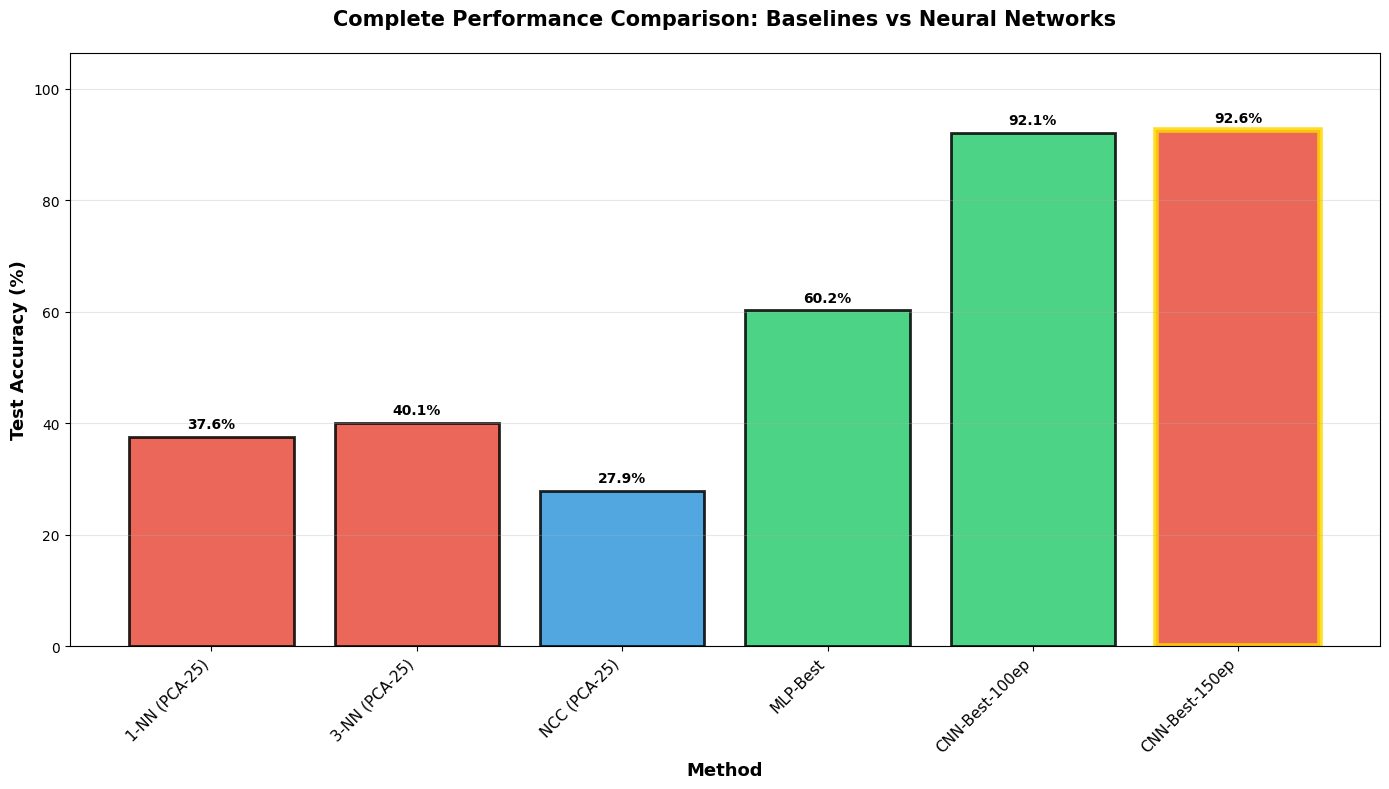

In [ ]:
fig, ax = plt.subplots(figsize=(14, 8))

methods = list(baseline_results.keys()) + list(all_results.keys())
accuracies = ([baseline_results[k]['accuracy'] for k in baseline_results.keys()] +
              [all_results[k]['test_accuracy'] for k in all_results.keys()])

colors = ['#e74c3c', '#e74c3c'] + ['#3498db'] + ['#2ecc71'] * (len(all_results) - 1)

bars = ax.bar(range(len(methods)), accuracies, color=colors, alpha=0.85,
              edgecolor='black', linewidth=2)

ax.set_ylabel('Test Accuracy (%)', fontweight='bold', fontsize=13)
ax.set_xlabel('Method', fontweight='bold', fontsize=13)
ax.set_title('Complete Performance Comparison: Baselines vs Neural Networks',
             fontweight='bold', fontsize=15, pad=20)
ax.set_xticks(range(len(methods)))
ax.set_xticklabels(methods, rotation=45, ha='right', fontsize=11)
ax.set_ylim([0, max(accuracies) * 1.15])
ax.grid(axis='y', alpha=0.3)

# Add values
for i, (bar, acc) in enumerate(zip(bars, accuracies)):
    ax.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 1,
            f'{acc:.1f}%',
            ha='center', va='bottom', fontsize=10, fontweight='bold')

# Highlight best
best_idx = accuracies.index(max(accuracies))
bars[best_idx].set_edgecolor('gold')
bars[best_idx].set_linewidth(4)

plt.tight_layout()
plt.savefig(f'{SAVE_PATH}/complete_comparison.svg', format='svg', bbox_inches='tight')
print("Saved: complete_comparison.svg")
plt.show()

## Training Curves

Saved: training_curves.svg


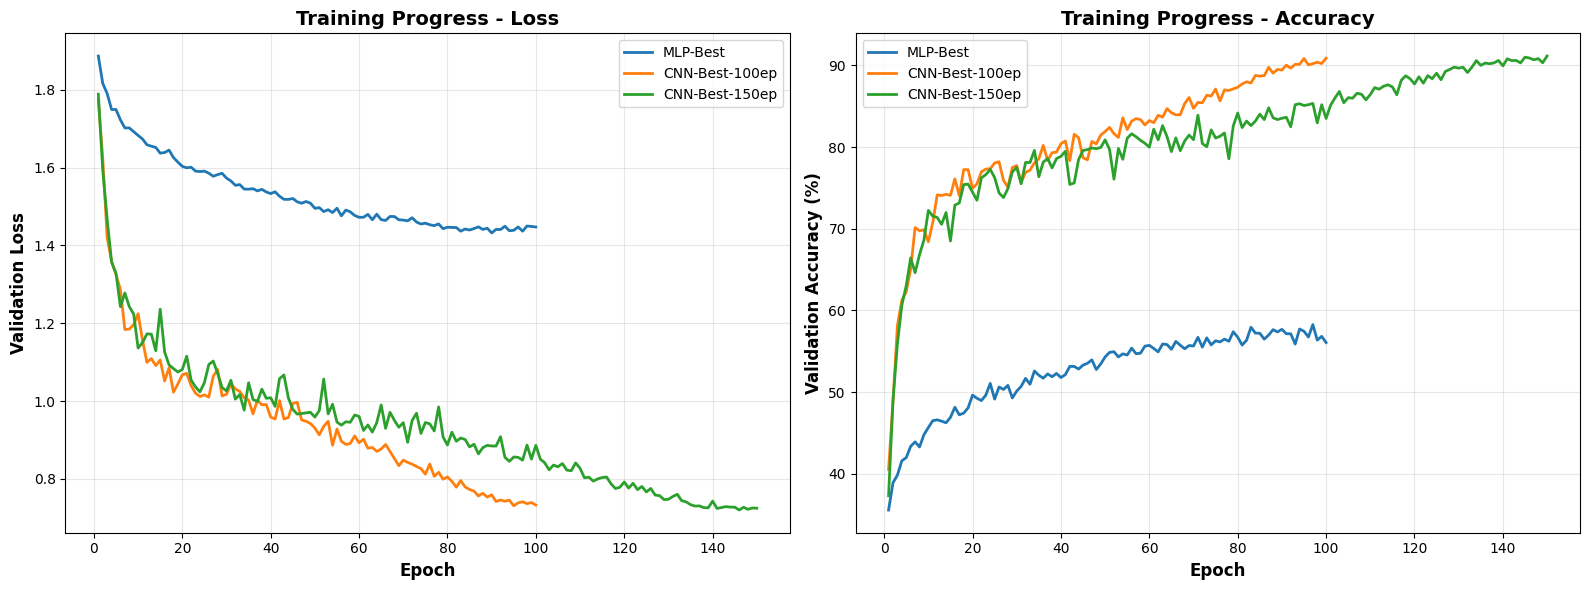

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

for name, result in all_results.items():
    epochs = range(1, len(result['history']['val_acc']) + 1)
    axes[0].plot(epochs, result['history']['val_loss'], label=name, linewidth=2)
    axes[1].plot(epochs, result['history']['val_acc'], label=name, linewidth=2)

axes[0].set_xlabel('Epoch', fontweight='bold', fontsize=12)
axes[0].set_ylabel('Validation Loss', fontweight='bold', fontsize=12)
axes[0].set_title('Training Progress - Loss', fontweight='bold', fontsize=14)
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)

axes[1].set_xlabel('Epoch', fontweight='bold', fontsize=12)
axes[1].set_ylabel('Validation Accuracy (%)', fontweight='bold', fontsize=12)
axes[1].set_title('Training Progress - Accuracy', fontweight='bold', fontsize=14)
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f'{SAVE_PATH}/training_curves.svg', format='svg', bbox_inches='tight')
print("Saved: training_curves.svg")
plt.show()

## Best Model Confusion Matrix

Saved: confusion_matrix_best.svg


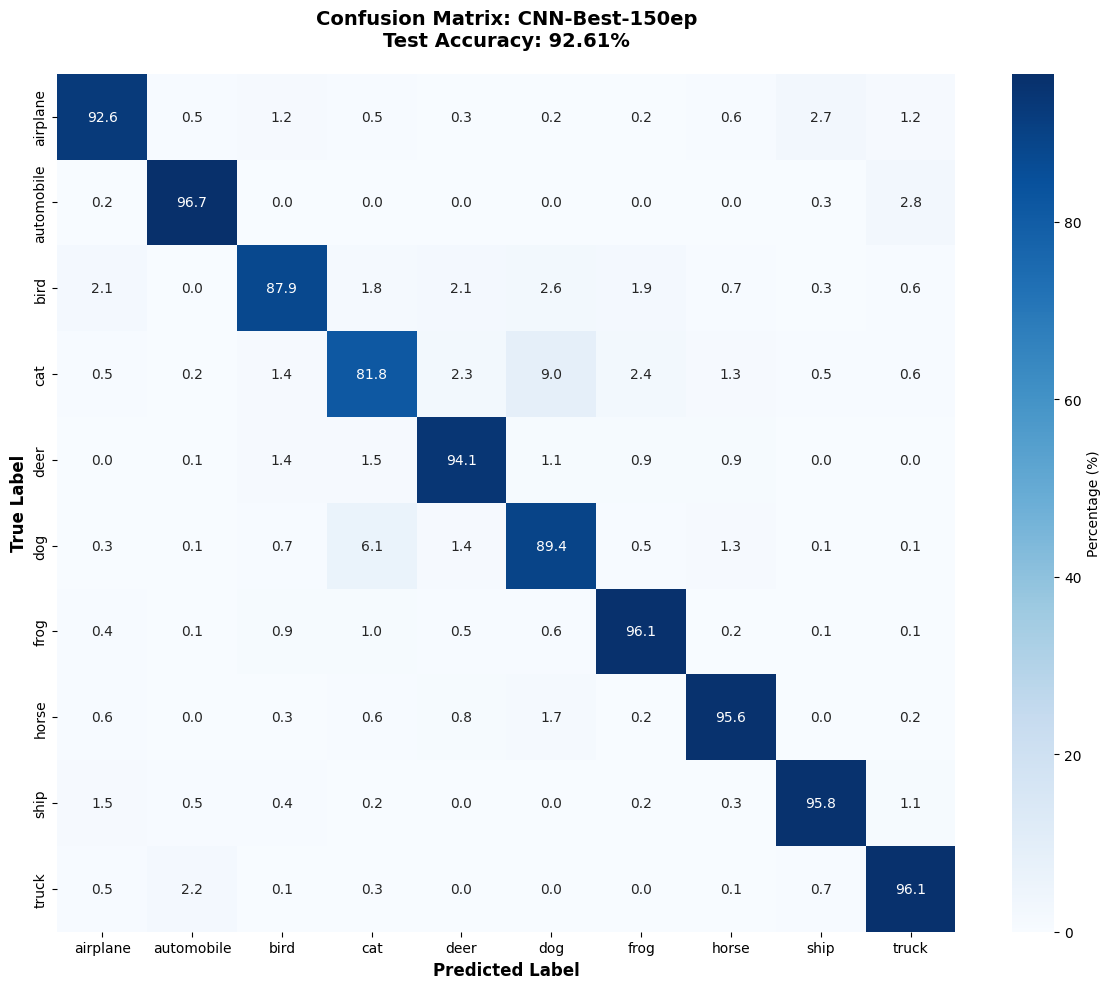

In [ ]:
best_name = max(all_results.keys(), key=lambda k: all_results[k]['test_accuracy'])
best_cm = all_results[best_name]['test_results']['confusion_matrix']

fig, ax = plt.subplots(figsize=(12, 10))
cm_norm = best_cm.astype('float') / best_cm.sum(axis=1)[:, np.newaxis] * 100

sns.heatmap(cm_norm, annot=True, fmt='.1f', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names,
            cbar_kws={'label': 'Percentage (%)'}, ax=ax)

ax.set_ylabel('True Label', fontweight='bold', fontsize=12)
ax.set_xlabel('Predicted Label', fontweight='bold', fontsize=12)
ax.set_title(f'Confusion Matrix: {best_name}\nTest Accuracy: {all_results[best_name]["test_accuracy"]:.2f}%',
             fontweight='bold', fontsize=14, pad=20)

plt.tight_layout()
plt.savefig(f'{SAVE_PATH}/confusion_matrix_best.svg', format='svg', bbox_inches='tight')
print("Saved: confusion_matrix_best.svg")
plt.show()

## Summary Dashboard

Saved: summary_dashboard.svg


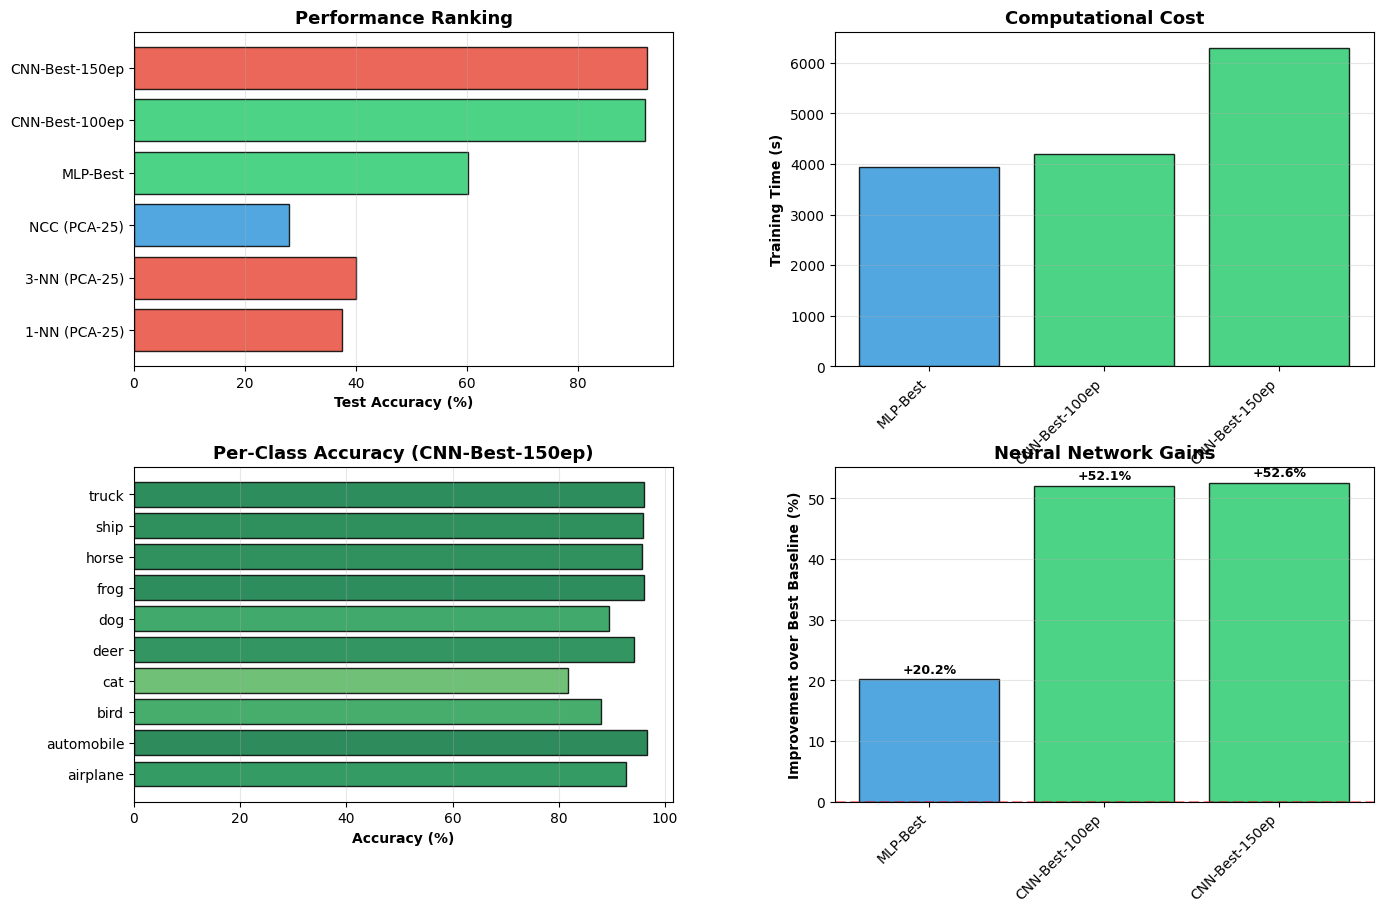

In [ ]:
fig = plt.figure(figsize=(16, 10))
gs = fig.add_gridspec(2, 2, hspace=0.3, wspace=0.3)

# Top left: Accuracy comparison
ax1 = fig.add_subplot(gs[0, 0])
ax1.barh(range(len(methods)), accuracies, color=colors, alpha=0.85, edgecolor='black')
ax1.set_yticks(range(len(methods)))
ax1.set_yticklabels(methods, fontsize=10)
ax1.set_xlabel('Test Accuracy (%)', fontweight='bold')
ax1.set_title('Performance Ranking', fontweight='bold', fontsize=13)
ax1.grid(axis='x', alpha=0.3)

# Top right: Training time
ax2 = fig.add_subplot(gs[0, 1])
times = [all_results[k]['training_time'] for k in all_results.keys()]
nn_names = list(all_results.keys())
ax2.bar(range(len(times)), times, color=['#3498db'] + ['#2ecc71'] * (len(times)-1),
        alpha=0.85, edgecolor='black')
ax2.set_xticks(range(len(times)))
ax2.set_xticklabels(nn_names, rotation=45, ha='right', fontsize=10)
ax2.set_ylabel('Training Time (s)', fontweight='bold')
ax2.set_title('Computational Cost', fontweight='bold', fontsize=13)
ax2.grid(axis='y', alpha=0.3)

# Bottom left: Per-class accuracy
ax3 = fig.add_subplot(gs[1, 0])
per_class = best_cm.diagonal() / best_cm.sum(axis=1) * 100
ax3.barh(range(10), per_class, color=plt.cm.RdYlGn(per_class/100),
         alpha=0.85, edgecolor='black')
ax3.set_yticks(range(10))
ax3.set_yticklabels(class_names, fontsize=10)
ax3.set_xlabel('Accuracy (%)', fontweight='bold')
ax3.set_title(f'Per-Class Accuracy ({best_name})', fontweight='bold', fontsize=13)
ax3.grid(axis='x', alpha=0.3)

# Bottom right: Improvement over baseline
ax4 = fig.add_subplot(gs[1, 1])
baseline_best = max([baseline_results[k]['accuracy'] for k in baseline_results.keys()])
improvements = [all_results[k]['test_accuracy'] - baseline_best for k in all_results.keys()]
ax4.bar(range(len(improvements)), improvements,
        color=['#3498db'] + ['#2ecc71'] * (len(improvements)-1),
        alpha=0.85, edgecolor='black')
ax4.set_xticks(range(len(improvements)))
ax4.set_xticklabels(list(all_results.keys()), rotation=45, ha='right', fontsize=10)
ax4.set_ylabel('Improvement over Best Baseline (%)', fontweight='bold')
ax4.set_title('Neural Network Gains', fontweight='bold', fontsize=13)
ax4.axhline(y=0, color='red', linestyle='--', linewidth=2, alpha=0.5)
ax4.grid(axis='y', alpha=0.3)

for i, imp in enumerate(improvements):
    ax4.text(i, imp + 1, f'+{imp:.1f}%', ha='center', fontsize=9, fontweight='bold')

plt.savefig(f'{SAVE_PATH}/summary_dashboard.svg', format='svg', bbox_inches='tight')
print("Saved: summary_dashboard.svg")
plt.show()

# **RESULTS SUMMARY & EXPORT**

In [ ]:
# Create summary DataFrame
summary_data = []

for name, result in baseline_results.items():
    summary_data.append({
        'Method': name,
        'Type': 'Baseline',
        'Test Accuracy (%)': result['accuracy'],
        'Training Time (s)': result['time']
    })

for name, result in all_results.items():
    method_type = 'MLP' if 'MLP' in name else 'CNN'
    summary_data.append({
        'Method': name,
        'Type': method_type,
        'Test Accuracy (%)': result['test_accuracy'],
        'Training Time (s)': result['training_time']
    })

df_summary = pd.DataFrame(summary_data)
df_summary = df_summary.sort_values('Test Accuracy (%)', ascending=False)

print("\nCOMPLETE RESULTS TABLE:")
print("─"*70)
print(df_summary.to_string(index=False))
print("─"*70)

# Save to CSV
df_summary.to_csv(f'{SAVE_PATH}/results_summary.csv', index=False)
print(f"Saved: results_summary.csv")

# Best performers
print("\nBEST PERFORMERS:")
print("─"*70)
print(f"Best Overall: {df_summary.iloc[0]['Method']:<25s} {df_summary.iloc[0]['Test Accuracy (%)']:.2f}%")
print(f"Best MLP:     {df_summary[df_summary['Type']=='MLP'].iloc[0]['Method']:<25s} "
      f"{df_summary[df_summary['Type']=='MLP'].iloc[0]['Test Accuracy (%)']:.2f}%")
print(f"Best CNN:     {df_summary[df_summary['Type']=='CNN'].iloc[0]['Method']:<25s} "
      f"{df_summary[df_summary['Type']=='CNN'].iloc[0]['Test Accuracy (%)']:.2f}%")
print(f"Best Baseline: {df_summary[df_summary['Type']=='Baseline'].iloc[0]['Method']:<25s} "
      f"{df_summary[df_summary['Type']=='Baseline'].iloc[0]['Test Accuracy (%)']:.2f}%")
print("─"*70)

# Improvements
baseline_best = df_summary[df_summary['Type']=='Baseline']['Test Accuracy (%)'].max()
nn_best = df_summary[df_summary['Type'].isin(['MLP', 'CNN'])]['Test Accuracy (%)'].max()

print("\nIMPROVEMENT ANALYSIS:")
print("─"*70)
print(f"Best Baseline Accuracy:      {baseline_best:.2f}%")
print(f"Best Neural Network Accuracy: {nn_best:.2f}%")
print(f"Absolute Improvement:         +{nn_best - baseline_best:.2f}%")
print(f"Relative Improvement:         {(nn_best/baseline_best - 1)*100:.1f}%")
print("─"*70)

# Per-class analysis
print(f"\nPER-CLASS ACCURACY ({best_name}):")
print("─"*70)
for i, (cls, acc) in enumerate(zip(class_names, per_class)):
    bar = '█' * int(acc/2)
    print(f"{cls:12s}: {acc:5.2f}% {bar}")
print("─"*70)

# Save all results
results_pkl = {
    'baseline_results': baseline_results,
    'nn_results': all_results,
    'summary_df': df_summary,
    'class_names': class_names,
    'pca_explained_var': explained_var
}

with open(f'{SAVE_PATH}/complete_results.pkl', 'wb') as f:
    pickle.dump(results_pkl, f)
print(f"\nComplete results saved: complete_results.pkl")



COMPLETE RESULTS TABLE:
──────────────────────────────────────────────────────────────────────
        Method     Type  Test Accuracy (%)  Training Time (s)
CNN-Best-150ep      CNN              92.61        6301.057425
CNN-Best-100ep      CNN              92.13        4189.394916
      MLP-Best      MLP              60.25        3945.809389
 3-NN (PCA-25) Baseline              40.05           8.836538
 1-NN (PCA-25) Baseline              37.60           9.494425
  NCC (PCA-25) Baseline              27.90           0.048500
──────────────────────────────────────────────────────────────────────
Saved: results_summary.csv

BEST PERFORMERS:
──────────────────────────────────────────────────────────────────────
Best Overall: CNN-Best-150ep            92.61%
Best MLP:     MLP-Best                  60.25%
Best CNN:     CNN-Best-150ep            92.61%
Best Baseline: 3-NN (PCA-25)             40.05%
──────────────────────────────────────────────────────────────────────

IMPROVEMENT ANALYSIS:


# **TIPS FOR REACHING 90%+ ACCURACY**

In [ ]:
current_best = df_summary.iloc[0]['Test Accuracy (%)']

if current_best >= 90:
    print(f"\nCONGRATULATIONS! You achieved {current_best:.2f}% accuracy!")
    print("   You have reached the 90%+ target!")
else:
    print(f"\nCurrent Best: {current_best:.2f}%")
    print(f"Gap to 90%: {90 - current_best:.2f}%\n")

    print("🔧 TUNING SUGGESTIONS TO REACH 90%+:")
    print("\nINCREASE EPOCHS:")
    print("   experiments['CNN-Best-200ep'] = {")
    print("       'model': BestCNN,")
    print("       'epochs': 200,  # ← Increase from 150")
    print("       'batch_size': 128,")
    print("       'lr': 0.1,")
    print("       'optimizer': 'SGD'")
    print("   }")

    print("\nADD WEIGHT DECAY (if not used):")
    print("   optimizer = optim.SGD(model.parameters(), lr=0.1,")
    print("                        momentum=0.9,")
    print("                        weight_decay=5e-4,  # ← Important!")
    print("                        nesterov=True)")

    print("\nTRY LARGER MODEL:")
    print("   - Increase filters: 64→96, 128→192, 256→384")
    print("   - Add more conv blocks (4 instead of 3)")

    print("\nLEARNING RATE WARMUP:")
    print("   Start with lr=0.01, gradually increase to 0.1 over 5 epochs")

    print("\nMIXUP AUGMENTATION:")
    print("   Implement mixup data augmentation for +1-2% boost")

    print("\nENSEMBLE:")
    print("   Train 3-5 models and average their predictions")

print("\n" + "━"*70)


CONGRATULATIONS! You achieved 92.61% accuracy!
   You have reached the 90%+ target!

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━


# **FINAL SUMMARY**

In [ ]:
print("\nAll files saved to Google Drive:")
print(f"   Folder: {SAVE_PATH}")
print("\n   Generated files:")
files = [
    'complete_comparison.svg',
    'training_curves.svg',
    'confusion_matrix_best.svg',
    'summary_dashboard.svg',
    'results_summary.csv',
    'complete_results.pkl'
]

for model_name in all_results.keys():
    files.append(f'{model_name}_model.pth')

for i, f in enumerate(files, 1):
    print(f"   {i:2d}. {f}")

print("\nFinal Statistics:")
print(f"• Baseline Methods: {len(baseline_results)}")
print(f"• Neural Networks: {len(all_results)}")
print(f"• Best Accuracy: {df_summary.iloc[0]['Test Accuracy (%)']:.2f}%")
print(f"• Best Method: {df_summary.iloc[0]['Method']}")
print(f"• Total Training Time: {sum([r['training_time'] for r in all_results.values()]):.1f}s")

if current_best >= 90:
    print(f"\nTARGET ACHIEVED: {current_best:.2f}% ≥ 90% ✅")
else:
    print(f"\nTARGET: {current_best:.2f}% / 90% ({90-current_best:.2f}% remaining)")


All files saved to Google Drive:
   Folder: /content/drive/MyDrive/NN_CIFAR10_Project

   Generated files:
    1. complete_comparison.svg
    2. training_curves.svg
    3. confusion_matrix_best.svg
    4. summary_dashboard.svg
    5. results_summary.csv
    6. complete_results.pkl
    7. MLP-Best_model.pth
    8. CNN-Best-100ep_model.pth
    9. CNN-Best-150ep_model.pth

Final Statistics:
• Baseline Methods: 3
• Neural Networks: 3
• Best Accuracy: 92.61%
• Best Method: CNN-Best-150ep
• Total Training Time: 14436.3s

TARGET ACHIEVED: 92.61% ≥ 90% ✅
